### Imports

In [1]:
import os
from os.path import isfile
from PIL import Image, ImageFile
import tqdm
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms, models
from torchvision.models import densenet121

import albumentations
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as F
from albumentations import Compose, Resize, Cutout, OneOf
from albumentations.imgaug.transforms import IAAPerspective, IAASharpen

from sklearn.model_selection import train_test_split
import sklearn.metrics

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
plt.gray()

<Figure size 432x288 with 0 Axes>

In [2]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='4'
device = torch.device("cuda")

### Dataset and DataLoader

In [4]:
df = pd.read_csv('train.csv')
df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [5]:
print('Unique values per column:')
{col:len(df[col].unique()) for col in df.columns}

Unique values per column:


{'image_id': 200840,
 'grapheme_root': 168,
 'vowel_diacritic': 11,
 'consonant_diacritic': 7,
 'grapheme': 1295}

In [6]:
class bengali(Dataset):
    """
    Dataset for bengali characters. A train test split is performed within the initialization
    to split the dataset into a training and validation set.
    """
    
    def __init__(self, root, subset='train', transform=None):
        self.root = os.path.expanduser(root)
        self.subset = subset
        self.transform = transform
        self.data_path = []
        self.df_og_labels = pd.read_csv('train.csv')
        
        train_indices, val_indices = train_test_split(df.index.values, test_size=0.2, random_state=42)
        self.df_train_labels = self.df_og_labels.loc[train_indices].sort_index().copy()
        self.df_val_labels = self.df_og_labels.loc[val_indices].sort_index().copy()
        
        def load_images(path):
            """
            returns all the sorted image paths.

            :param path: path to where the images are stored
            :return: array with all the paths to the images
            """
            ls_image_ids = [f[:-4] for f in os.listdir(path) if isfile(os.path.join(path, f))]
            df_image_ids = pd.DataFrame({'image_id':ls_image_ids})
            
            if self.subset == 'train':
                df_filt = pd.merge(df_image_ids, 
                                   self.df_train_labels, 
                                   on='image_id')
            elif self.subset == 'val':
                df_filt = pd.merge(df_image_ids, 
                                   self.df_val_labels, 
                                   on='image_id')
            else:
                print('Subset must be one of "train" or "val"!')
            
            df_filt['image_paths'] = df_filt['image_id'].apply(lambda x: os.path.join(path, x+'.png'))
            images_dir = list(df_filt['image_paths'])
            
            # sort using image number as a key so the paths are sorted in the same order as the train.csv
            images_dir.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

            return images_dir

        self.data_path = load_images(self.root + '/train')
        
        if self.subset == 'train':
            self.df_labels = self.df_train_labels.copy()
        elif self.subset == 'val':
            self.df_labels = self.df_val_labels.copy()
            
    def __getitem__(self, idx):
        img = np.array(Image.open(self.data_path[idx]), dtype=np.uint8)
        arr_label = self.df_labels.iloc[idx, 1:4].values.astype(int) # grapheme, vowel, consonant label

        if self.transform is not None:
            img = self.transform(image=img)
            img = transforms.Compose([transforms.ToTensor()])(img['image'])
            img = torch.cat([img, img, img]) # from 1 channel to 3 channel

        return img, arr_label
    
    def __len__(self):
        return len(self.data_path)

In [7]:
new_size = 224
batch_size = 64

train_dataset = bengali(root='.',
                        subset='train',
                        transform=Compose([Resize(new_size,new_size),
                                           OneOf([Cutout(num_holes=1, p=0.5, max_h_size=100, max_w_size=100),
                                                  GridMask(num_grid=3, rotate=10, mode=0, p=0.8),
                                                  GridMask(num_grid=3, rotate=10, mode=2, p=0.5)], p=1)]))

trainacc_dataset = bengali(root='.',
                           subset='train',
                           transform=Compose([Resize(new_size,new_size)]))

val_dataset = bengali(root='.',
                      subset='val',
                      transform=Compose([Resize(new_size,new_size)]))
val_dataset, throwaway = torch.utils.data.random_split(val_dataset, (600, len(val_dataset)-600))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

trainacc_loader = DataLoader(dataset=trainacc_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=4)

In [8]:
print('Train dataset len:', len(train_dataset))
print('Train accuracy dataset len:', len(trainacc_dataset))
print('Validation dataset len:', len(val_dataset))

Train dataset len: 160672
Train accuracy dataset len: 160672
Validation dataset len: 600


Inspect images to make sure the augmentations look reasonable.

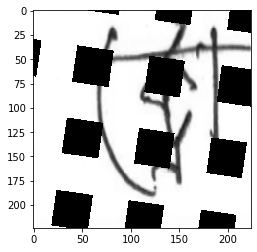

In [9]:
plt.imshow(train_dataset[0][0].permute(1,2,0))

In [10]:
train_dataset[0][1] # grapheme, vowel, consonant label

array([15,  9,  5])

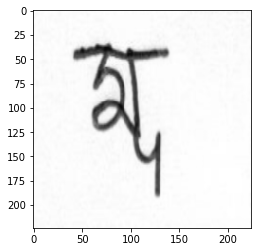

In [11]:
plt.imshow(val_dataset[0][0].permute(1,2,0))

In [12]:
val_dataset[0][1]

array([115,   5,   0])

### Model

In [13]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x

# https://discuss.pytorch.org/t/how-can-i-replace-the-forward-method-of-a-predefined-torchvision-model-with-my-customized-forward-function/54224/6
class myDenseNet(nn.Module):
    def __init__(self, init_net):
        super().__init__()
        self.initial_net = init_net
        self.drop_layer = nn.Dropout(p=0.2)
        self.grapheme1 = nn.Linear(in_features=1024, out_features=512, bias=True)
        self.grapheme2 = nn.Linear(in_features=512, out_features=168, bias=True)
        self.vowel = nn.Linear(in_features=1024, out_features=11, bias=True)
        self.cons = nn.Linear(in_features=1024, out_features=7, bias=True)
        
    def forward(self, x):
        x = self.initial_net(x)
        x = self.drop_layer(x)
        x1 = self.grapheme2(self.grapheme1(x))
        x2 = self.vowel(x)
        x3 = self.cons(x)
        
        return x1, x2, x3

init_net = densenet121(pretrained=True)
init_net.classifier = Identity()

net = myDenseNet(init_net)
net.to(device)

myDenseNet(
  (initial_net): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

In [14]:
for x in train_loader:
    print(type(x))
    print('imgs shape', x[0].shape)
    print('label shape', x[1].shape)
    break

<class 'list'>
imgs shape torch.Size([64, 3, 224, 224])
label shape torch.Size([64, 3])


In [15]:
def train(net, epoch_num, loader, optimizer, scheduler):    
    """
    Function to train model. Loss has a 2.5 multiplier on grapheme root
    to account for the fact that it is weighted higher in the kaggle
    evaluation metric.
    """

    g, v, c = 0, 0, 0
    
    net.train()

    for batch in tqdm.tqdm(loader, desc="Train Batch"):
        imgs = batch[0].to(device)
        true_label = batch[1].to(device)
        
        y_hats = net(imgs) # 3 arrays, each of B x 168, B x 11, B x 7 where B = batch size
        criterion = nn.CrossEntropyLoss()
        
        grapheme_loss = criterion(y_hats[0], true_label[:, 0])
        vowel_loss = criterion(y_hats[1], true_label[:, 1])
        cons_loss = criterion(y_hats[2], true_label[:, 2])
        
        tot_loss = (2.5*grapheme_loss) + vowel_loss + cons_loss
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # backward + optimize only if in training phase
        tot_loss.backward()
        optimizer.step() # update the weights
    
def val(net, epoch_num, loader):
    """
    Function to perform valiation. Recall is calculated in the same way
    as it would be on the kaggle leaderboard.
    """
    
    tot = 0.0
    total_recall = [0., 0., 0.]
    g, v, c = 0, 0, 0
    
    # Set model to evaluate mode
    net.eval()
    
    for batch in tqdm.tqdm(loader, desc="Val Batch"):
        imgs = batch[0].to(device)
        true_label = batch[1].to(device)
        
        y_hats = net(imgs) # 3 arrays, each of B x 168, B x 11, B x 7 where B = batch size
        criterion = nn.CrossEntropyLoss()
        
        g_pred = y_hats[0].argmax(axis=1)
        v_pred = y_hats[1].argmax(axis=1)
        c_pred = y_hats[2].argmax(axis=1)
        
        # add recall score per batch per g/v/c to list
        total_recall[0] += sklearn.metrics.recall_score(true_label[:, 0].cpu(), g_pred.cpu(), average='macro')
        total_recall[1] += sklearn.metrics.recall_score(true_label[:, 1].cpu(), v_pred.cpu(), average='macro')
        total_recall[2] += sklearn.metrics.recall_score(true_label[:, 2].cpu(), c_pred.cpu(), average='macro')

        g += ((g_pred == true_label[:, 0]).sum()).item()
        v += ((v_pred == true_label[:, 1]).sum()).item()
        c += ((c_pred == true_label[:, 2]).sum()).item()
    
    print('val got ', g, 'out of 40168 graphemes right')
    print('val got ', v, 'out of 40168 vowels right')
    print('val got ', c, 'out of 40168 consonants right')
    
    avg_recall = [i/np.float(len(loader)) for i in total_recall]
    return np.average(avg_recall, weights=[2,1,1])

Train for a couple of epochs to make sure it works. Run for the full 100+ epochs using the .py version.

In [ ]:
lr = (3e-5)*32 # 3e-5 was used for batch size of 2. since batch size here is 64, multiply lr by 2^5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='max',
                                                       factor=0.5,
                                                       patience=5,
                                                       verbose=True,
                                                       threshold=1e-4,
                                                       threshold_mode='abs')
n_epochs = 2
best_recall = -np.inf
ls_train_acc = []
ls_val_acc = []

for epoch in tqdm.tnrange(n_epochs, desc="Epochs"):
    
    # train the model
    start_time = time.time()
    train(net=net,
          epoch_num=epoch, 
          loader=train_loader,
          optimizer=optimizer,
          scheduler=scheduler)
    print('Time to train epoch', epoch, ':', time.time()-start_time)

    # calculate training accuracy
    start_time = time.time()
    train_acc = val(net=net,
                    epoch_num=epoch, 
                    loader=trainacc_loader)
    print('Time to check training recall in epoch', epoch, ':', time.time()-start_time)
    print('Epoch', epoch, 'training recall: ', train_acc)
    ls_train_acc.append(train_acc)

    # calculate validation accuracy
    start_time = time.time()
    val_acc = val(net=net,
                  epoch_num=epoch,
                  loader=val_loader)
    print('Time to validate epoch', epoch, ':', time.time()-start_time)
    print('Epoch', epoch, 'val recall: ', val_acc)
    ls_val_acc.append(val_acc)
    scheduler.step(val_acc)

    if val_acc > best_recall:
        print('New best validation recall is', val_acc)
        best_recall = val_acc
#         torch.save(net, 'saved_models/densenet121_co_gm.pt')

Train Batch:  81%|████████▏ | 2042/2511 [10:46<02:30,  3.12it/s]